In [1]:
from mmdet.apis import init_detector, inference_detector
import mmcv
import matplotlib.pyplot as plt
import cv2
import os
import json
from tqdm.notebook import tqdm
import numpy as np
import logging

In [3]:
from mmdet.apis import init_detector, inference_detector
import mmcv
import matplotlib.pyplot as plt
import cv2
import os
import json
from tqdm.notebook import tqdm
import numpy as np
import logging

### Path to OCR of the video
data = open('../../data/ocr_results/results/ocr_with_gameclockrunning/2018-11-28_Virginia_at_Maryland/2018-11-28_Virginia_at_Maryland_ocr.json')
data = json.load(data)

### Config and model weights path
config_file = 'configs/yolo/basket_yolov3_d53_mstrain-608_273e_coco.py'
checkpoint_file = 'work_dirs/basket_yolov3_every_epoch/epoch_60.pth'

### Path to the video
video_path = '../../data/videos/videos/2018-11-28_Virginia_at_Maryland.mp4'

# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')

logging.basicConfig(level=logging.DEBUG)
### Comment if you want to DEBUG
logging.disable(logging.DEBUG)

### Load the video using MMCV
video = mmcv.VideoReader(video_path)

### Output video
out_all = cv2.VideoWriter('output_basket.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 20, (1280, 720))

### Temp variables
en = 0
proc = 0
pbar = tqdm(total=video.frame_cnt)
has_pred = 0
basket = 0

### Start prediction
for frame in video:

    ### Check if it is game moment using OCR
    idx = str(en)
    if not data['results'][idx]['score_bug_present'] or not data['results'][idx]['game_clock_running']:
        en += 1
        continue

    ### Predict the image and update stats
    result = inference_detector(model, frame)
    if len(result[0]) != 0: basket += 1
    frame = mmcv.imshow_bboxes(frame, result, colors='green', thickness=2, show=False)
    out_all.write(frame)

    ### Update stats
    en += 1
    proc += 1
    if proc > 1000: break
    pbar.update(1)

out_all.release()
print(basket)
pbar.close()

765



# Detect and Track


### First, load the ocr results, model weights and the config file

In [3]:
### Path to OCR of the video
data = open('../../data/ocr_results/results/ocr_with_gameclockrunning/2018-11-28_Virginia_at_Maryland/2018-11-28_Virginia_at_Maryland_ocr.json')
data = json.load(data)

### Config and model weights path
config_file = 'configs/yolo/custom_yolov3_d53_mstrain-608_273e_coco.py'
checkpoint_file = 'work_dirs/yolov3_d53_mstrain-608_273e_coco/epoch_273.pth'

### Path to the video
video_path = '../../data/videos/videos/2018-11-28_Virginia_at_Maryland.mp4'

# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')

In [326]:
logging.basicConfig(level=logging.DEBUG)
### Comment if you want to DEBUG
logging.disable(logging.DEBUG)

### Load the video using MMCV
video = mmcv.VideoReader(video_path)

### Temp variables
en = 0
proc = 0
pbar = tqdm(total=video.frame_cnt)
has_pred = 0


### Create the tracker
tracker = Tracker()

### Start prediction
for frame in video:
    
    ### Check if it is game moment using OCR
    idx = str(en)
    if not data['results'][idx]['score_bug_present'] or not data['results'][idx]['game_clock_running']:
        en += 1
        continue
    
    
    ### Predict the image and update stats
    result = inference_detector(model, frame)
    if len(result[0]) != 0: has_pred+=1
        
    ### Update tracker results
    tracker.update(result)
    
    ### Update stats
    en += 1
    proc += 1
    if proc > 600: break  
    pbar.update(1)
    
    
pbar.close()

In [327]:
### Here, I check the number of collected detection and processed frames
print(len(tracker.current_tracks), proc)

(601, 601, 12.398399120853863)

In [333]:
### Here I run the function which search for missing detections intervals in tracker.current_tracks 
### and interpolates its values. The below threshold is pointing how many missed values to interpolate.
how_much_to_interpoate = 6
tracker.calc_missing_intervals(how_much_to_interpoate)

0

In [325]:
class Tracker():
    
    def __init__(self):
        
        self.current_tracks = []  ### List of all tracks 
        self.temp_tracks = [] ### List of temporary tracks

        self.temp_track_len = 3 ### How much tracks to collect before merging into main track
        self.thresh_distance = 13 ### Euclidean distance threshold
        self.avg_dist = []
   

    def convert_to_center(self, result):
        return np.array([int((result[2] + result[0])/2), int((result[3] + result[1])/2)])

    
    def update(self, result):
        
        ### Check if we have any detections
        if len(result[0])==0:  
            
            self.current_tracks.append(None)
            self.temp_tracks = []
            self.zero_res = result
            
        elif len(result[0])==1:
            self.single_res = result[0][0]
            
            logging.debug("SINGLE RES")

            ### If we don't have approved tracks or no good history
            if len(self.current_tracks)==0 or self.current_tracks[-1] is None:
                logging.debug("NONE TRACK CONTINUED")
                ### if we don't temporary tracks we update temp tracks or we lost the track, else we check its distance to previous temp track
                if len(self.temp_tracks)==0:
                    self.temp_tracks.append(result[0][0])
                    self.current_tracks.append(None)

                else:
                    curr_center = self.convert_to_center(result[0][0])
                    last_center = self.convert_to_center(self.temp_tracks[-1])
                    self.avg_dist.append(np.linalg.norm(curr_center  - last_center))
                    
                    if np.linalg.norm(curr_center  - last_center) <  self.thresh_distance:
                        logging.debug("DIST CRITERIA SATISFIED")
                        self.temp_tracks.append(result[0][0]) 
                        
                        if len(self.temp_tracks) < self.temp_track_len:
                            self.current_tracks.append(None)
                        else:
                            logging.debug("CURRENT_TRACK UPDATED-------------------")
                            self.current_tracks.append(None)
                            self.current_tracks[-len(self.temp_tracks):] = self.temp_tracks.copy()
                            self.temp_tracks = []

                    else:
                        self.current_tracks.append(None)
                        self.current_tracks[-(len(self.temp_tracks)+1):] = [None for _ in range(len(self.temp_tracks)+1)]
                        self.temp_tracks = []

            else:
#                 self.temp_tracks = []
                ### Now, we work with tracks that have history greater than 5
                logging.debug("CURRENT TRACK CONTINUED")
                curr_center = self.convert_to_center(result[0][0])
                last_canter = self.convert_to_center(self.current_tracks[-1])
                
                if np.linalg.norm(curr_center - last_canter) <  self.thresh_distance:
                    logging.debug("GOOD TRACK APPENDED")
                    self.avg_dist.append(np.linalg.norm(curr_center - last_canter))
                    self.current_tracks.append(result[0][0])           
                else:
                    logging.debug("BAD TRACK APPENDED")
                    self.current_tracks.append(None)

        elif len(result[0])>1:
            self.multi_res = result
            
            logging.debug("MULTI RES")
#             self.temp_tracks = []
            
            if len(self.current_tracks)==0 or self.current_tracks[-1] is None:
                
                if len(self.temp_tracks)>0:
                    appended = False
                    
                    for i in range(len(result[0])):

                        curr_res = result[0][i]
                        curr_center = self.convert_to_center(curr_res)
                        last_center = self.convert_to_center(self.temp_tracks[-1])
                        if np.linalg.norm(curr_center - last_center) <  self.thresh_distance:
                                                                           
                            self.temp_tracks.append(result[0][0]) 
                            if len(self.temp_tracks) < self.temp_track_len:
                                self.current_tracks.append(None)
                            else:
                                logging.debug("CURRENT_TRACK UPDATED-------------------")
                                self.current_tracks.append(None)
                                self.current_tracks[-len(self.temp_tracks):] = self.temp_tracks.copy()
                                self.temp_tracks = []                         
                            
                            appended = True                       
                            break
                            
                    if not appended:
                        self.current_tracks.append(None)
                        self.current_tracks[-(len(self.temp_tracks)+1):] = [None for _ in range(len(self.temp_tracks)+1)]
                        self.temp_tracks = []    
                        
                else:
                    self.current_tracks.append(None)
            
            else:
#                 self.current_tracks.append(None)
                self.temp_tracks = []
                appended = False
                for i in range(len(result[0])):

                    curr_res = result[0][i]
                    curr_center = self.convert_to_center(curr_res)
                    last_center = self.convert_to_center(self.current_tracks[-1])
                    if np.linalg.norm(curr_center - last_center) <  self.thresh_distance:
                        appended = True
                        self.current_tracks.append(curr_res)                         
                        break

                if not appended:
                    self.current_tracks.append(None)
                    
                    
    def calc_missing_intervals(self, length=2):
    
        i=0
        j=0
        misses = 0
        while i<len(self.current_tracks) and j<len(self.current_tracks):
            if self.current_tracks[i] is not None:
                i += 1
                j = i       
            elif self.current_tracks[i] is None and self.current_tracks[j] is None:
                j += 1
            elif self.current_tracks[i] is None and self.current_tracks[j] is not None and 0 < (j - i) <= length:
                interp_tracks = self.interpolate_bboxes(self.current_tracks[i-1:j+1])
                self.current_tracks[i-1:j+1] = interp_tracks                
                i = j           
                misses += 1           
            elif self.current_tracks[i] is None and self.current_tracks[j] is not None and (j - i) > length:
                i=j


        if 0 < (j - i) <= length:
            misses += 1

        return misses
    
    
    def interpolate_bboxes(self, tracks):
        first = tracks[0]
        last = tracks[-1]

        first_center = [ (first[2] + first[0]) / 2, (first[3] + first[1]) / 2]
        last_center = [(last[2] + last[0]) / 2, (last[3] + last[1]) / 2]

        half_width = ((abs(first[2] - first[0]) + abs(last[2] - last[0])) / 2) / 2
        half_height = ((abs(first[3] - first[1]) + abs(last[3] - last[1])) / 2) / 2


        i = 1

        while i < len(tracks)-1:
            new_x = first_center[0] + ((i + 1) / len(tracks)) * (last_center[0] - first_center[0])
            new_y = first_center[1] + ((i + 1) / len(tracks)) * (last_center[1] - first_center[1])

            new_bbox = np.array([new_x - half_width, new_y - half_height, new_x + half_width, new_y + half_height, first[-1]])

            tracks[i] = new_bbox

            i+=1


        return tracks

# Visualize after tracker results

### After we process the video, we have all the processed detections in tracker.current_tracks (list of bboxes). The indecies of this list corresponds to index of the frame.

In [335]:
config_file = 'configs/yolo/custom_yolov3_d53_mstrain-608_273e_coco.py'
checkpoint_file = 'work_dirs/yolov3_d53_mstrain-608_273e_coco/epoch_273.pth'

# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')

# test a video and show the results
video = mmcv.VideoReader('../../data/videos/videos/2018-11-28_Virginia_at_Maryland.mp4')
out = cv2.VideoWriter('output_tracker.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 15, (1280,720))

en = 0
proc = 0
not_none = 0
for frame in video:
    idx = str(en)
    if not data['results'][idx]['score_bug_present'] or not data['results'][idx]['game_clock_running']:
        en += 1
        continue
    
    if tracker.current_tracks[proc] is not None:
        not_none += 1 
        result = np.expand_dims(tracker.current_tracks[proc][:4], axis=0)
        frame = mmcv.imshow_bboxes(frame, result, show=False, thickness=1, colors=['green'])

    
    out.write(frame)

    en += 1
    proc += 1
    if proc > 500:break
    
    
    
out.release()

## DO NOT SCROLL DOWN

### Inference basket and ball together

In [2]:
### Path to OCR of the video
data = open('../../data/ocr_results/results/ocr_with_gameclockrunning/2018-11-28_Virginia_at_Maryland/2018-11-28_Virginia_at_Maryland_ocr.json')
data = json.load(data)

### Config and model weights path
config_file = 'configs/yolo/basketball_yolov3_d53_mstrain-608_273e_coco.py'
checkpoint_file = 'work_dirs/basketball_yolov3-608_273e/epoch_273.pth'

### Path to the video
video_path = '../../data/videos/videos/2018-11-28_Virginia_at_Maryland.mp4'

# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')

In [32]:
logging.basicConfig(level=logging.DEBUG)
### Comment if you want to DEBUG
logging.disable(logging.DEBUG)

### Load the video using MMCV
video = mmcv.VideoReader(video_path)

### Output video
out_all = cv2.VideoWriter('output_basketball.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 1, (1280,720))


### Temp variables
en = 0
proc = 0
pbar = tqdm(total=video.frame_cnt)
has_pred = 0
basket = 0

### Start prediction
for frame in video:
    
    ### Check if it is game moment using OCR
    idx = str(en)
    if not data['results'][idx]['score_bug_present'] or not data['results'][idx]['game_clock_running']:
        en += 1
        continue
    
    
    ### Predict the image and update stats
    result = inference_detector(model, frame)
    if len(result[0])!=0: basket +=1
#     frame = mmcv.imshow_bboxes(frame, result, colors='green', show=False)
#     out_all.write(frame)
                
    
    ### Update stats
    en += 1
    proc += 1
    if proc > 1000: break  
    pbar.update(1)
    
out_all.release()
print(basket) 
pbar.close()

185



In [26]:
result

[array([], shape=(0, 5), dtype=float32),
 array([[3.0415109e+02, 3.6792111e+02, 3.3019223e+02, 3.9406897e+02,
         1.1407311e-02]], dtype=float32)]

In [24]:
lol_frame = mmcv.imshow_bboxes(frame, result, colors='red', show=False)#, np.array([0,1]),  ['basket', 'ball'])

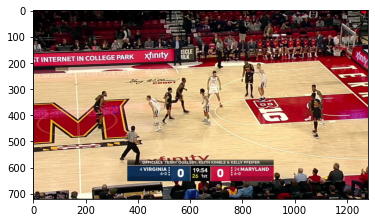

In [25]:
plt.imshow(lol_frame)

# Inference single class

In [2]:
### Path to OCR of the video
data = open('../../data/ocr_results/results/ocr_with_gameclockrunning/2018-11-28_Virginia_at_Maryland/2018-11-28_Virginia_at_Maryland_ocr.json')
data = json.load(data)

### Config and model weights path
config_file = 'configs/yolo/basket_yolov3_d53_mstrain-608_273e_coco.py'
checkpoint_file = 'work_dirs/basket_yolov3_every_epoch/epoch_60.pth'

### Path to the video
video_path = '../../data/videos/videos/2018-11-28_Virginia_at_Maryland.mp4'

# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')

In [3]:
logging.basicConfig(level=logging.DEBUG)
### Comment if you want to DEBUG
logging.disable(logging.DEBUG)

### Load the video using MMCV
video = mmcv.VideoReader(video_path)

### Output video
out_all = cv2.VideoWriter('output_basket.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 1, (1280,720))


### Temp variables
en = 0
proc = 0
pbar = tqdm(total=video.frame_cnt)
has_pred = 0
basket = 0

### Start prediction
for frame in video:
    
    ### Check if it is game moment using OCR
    idx = str(en)
    if not data['results'][idx]['score_bug_present'] or not data['results'][idx]['game_clock_running']:
        en += 1
        continue
    
    
    ### Predict the image and update stats
    result = inference_detector(model, frame)
    if len(result[0])!=0: basket +=1
    frame = mmcv.imshow_bboxes(frame, result, colors='green', show=False)
    out_all.write(frame)
                
    
    ### Update stats
    en += 1
    proc += 1
    if proc > 1000: break  
    pbar.update(1)
    
out_all.release()
print(basket) 
pbar.close()

/home/ubuntu/oljike/BallTracking/mmdetection/mmdet/models/dense_heads/yolo_head.py:270: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  conf_inds = conf_pred.ge(conf_thr).nonzero().flatten()


765



### Test results

In [3]:
import pickle 
with open('work_dirs/luba/ball_detections_test.json') as f:
    luba = json.load(f) 
    
luba_ids = []

luba_new = {}
for k,v in luba.items():
    luba_new[int(k)] = v
#     luba_ids.append(k)
    
luba_ids = [int(x) for x in luba_ids]
print(sorted(luba_ids), len(luba_ids))

import collections

od = collections.OrderedDict(sorted(luba_new.items()))

new_od = list(od.items())

last_od = [[np.array(x[1]).astype(np.float32)] for x in new_od]

with open('work_dirs/yolov3_d53_mstrain-608_273e_coco/result.pkl', 'rb') as f:
    my_res = pickle.load(f)
    
with open('work_dirs/luba/ball_detections_test.pkl', 'wb') as f:
    pickle.dump(last_od, f)

## VISUALIZE FRAMES

In [12]:
import mmcv
test = mmcv.load('../../data/ballTracking/BallDataset_test.json')

# out_my = cv2.VideoWriter('output_mine.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 1, (1280,720))
# out_luba = cv2.VideoWriter('output_luba.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 1, (1280,720))


out_all = cv2.VideoWriter('output_all.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 1, (1280,720))

font = cv2.FONT_HERSHEY_SIMPLEX 
  
# org 
org = (10, 50) 
org2 = (10, 80)  
# fontScale 
fontScale = 1

color = (0, 255, 0) 
color1 = (0, 0, 255) 
thickness = 2

for en, x in enumerate(test['images']):
    if en==0: continue
    
    path = os.path.join('../../data/ballTracking/ball_frames/', x['file_name'])
    img = cv2.imread(path)

    mine = img.copy()
    luba = img.copy()
    bboxes_my = my_res[en]
    bboxes_luba = last_od[en]
    
    all_ = mmcv.imshow_bboxes(img, bboxes_my, show=False, thickness=1, colors=['green'])
    all_ = mmcv.imshow_bboxes(img, bboxes_luba, show=False, thickness=1, colors=['red'])

    all_ = cv2.putText(all_, 'RED - OLD', org, font,  
                   fontScale, color1, thickness, cv2.LINE_AA)
    all_ = cv2.putText(all_, 'GREEN - NEW', org2, font,  
                   fontScale, color, thickness, cv2.LINE_AA)

    out_all.write(all_)
    
    
    if en>50:
        break
    
    
out_all.release()